In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


## **Data Loading**

In [2]:
train_data = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test_data = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

## **Library imports**

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import r2_score
import warnings

warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

## **Basic Dataset info**

In [4]:
print(f"Train Dataset shape: {train_data.shape}")
train_data.head()

Train Dataset shape: (116023, 52)


,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,61421,(not set),not available in demo dataset,domain1,0,not available in demo dataset,1,not available in demo dataset,Washington,youtube.com,1,not available in demo dataset,1500100799,Windows,Northern America,referral,NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Redmond,NaN,Seattle-Tacoma WA,1,8,not available in demo dataset,/intl/hr/yt/about/,1,20170714,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1
1,True,0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,72287,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,California,(direct),1,not available in demo dataset,1495262065,Macintosh,Northern America,(none),NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Mountain View,NaN,San Francisco-Oakland-San Jose CA,1,8,not available in demo dataset,NaN,1,20170519,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1
2,True,0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,25180,(not set),not available in demo dataset,domain1,0,not available in demo dataset,2,not available in demo dataset,Lombardy,google,1,not available in demo dataset,1508510328,Windows,Southern Europe,organic,NaN,not available in demo dataset,Italy,not available in demo dataset,NaN,Not Socially Engaged,Milan,NaN,(not set),6,8,not available in demo dataset,NaN,NaN,20171020,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,41295,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,youtube.com,1,not available in demo dataset,1483431838,Windows,Eastern Asia,referral,NaN,not available in demo dataset,Japan,not available in demo dataset,NaN,Not Socially Engaged,not available in demo dataset,NaN,not available in demo dataset,1,8,not available in demo dataset,/yt/about/ja/,1,20170103,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1
4,True,"88,950,000",Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,113697,(not set),not available in demo dataset,domain1,0,not available in demo dataset,1,not avai

In [5]:
print(f"Test Dataset shape: {test_data.shape}")
test_data.head()

Test Dataset shape: (29006, 51)


,userChannel,date,browser,device.browserSize,device.browserVersion,deviceType,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,os,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.continent,locationCountry,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,socialEngagementType,totals.bounces,totalHits,new_visits,pageViews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource,sessionId,sessionNumber,sessionStart,userId,locationZone,geoCluster,browserMajor,screenSize,gclIdPresent
0,Social,20170508,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,domain2,not available in demo dataset,not available in demo dataset,Northern America,Not Socially Engaged,NaN,11,NaN,10,1,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,referral,/a/google.com/forum/,groups.google.com,1494262567,2,1494262567,59555,8,Region_2,not available in demo dataset,medium,0
1,Organic Search,20170405,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Palo Alto,Americas,United States,San Francisco-Oakland-San Jose CA,domain1,not available in demo dataset,California,Northern America,Not Socially Engaged,NaN,9,1,9,1,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,1491433811,1,1491433811,6394,8,Region_1,not available in demo dataset,medium,0
2,Organic Search,20170308,Safari,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Philadelphia,Americas,United States,Philadelphia PA,domain2,not available in demo dataset,Pennsylvania,Northern America,Not Socially Engaged,NaN,2,1,2,1,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,1489001815,1,1489001815,38969,8,Region_5,not available in demo dataset,medium,0
3,Referral,20171113,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,domain2,not available in demo dataset,not available in demo dataset,Northern America,Not Socially Engaged,NaN,3,NaN,3,1,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,referral,/document/d/1GSpeJSCBhxRNya7kiUbBKO3rR20jBBBF3...,docs.google.com,1510593024,30,1510593024,120027,8,Region_2,not available in demo dataset,medium,0
4,Organic Search,20161212,Chrome,not available in demo dataset,not available in demo dataset,deskto

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   userChannel                                   29006 non-null  object 
 1   date                                          29006 non-null  int64  
 2   browser                                       29006 non-null  object 
 3   device.browserSize                            29006 non-null  object 
 4   device.browserVersion                         29006 non-null  object 
 5   deviceType                                    29006 non-null  object 
 6   device.flashVersion                           29006 non-null  object 
 7   device.isMobile                               29006 non-null  bool   
 8   device.language                               29006 non-null  object 
 9   device.mobileDeviceBranding                   29006 non-null 

## **Missing Value Analysis**

In [8]:
#missing value analysis for train data
missing_data = train_data.isnull().sum()
missing_percentage = (missing_data / len(train_data)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': round(missing_percentage,2)
}).sort_values('Missing_Count', ascending=False)
missing_summary[missing_summary['Missing_Count'] > 0]

,Missing_Count,Missing_Percentage
trafficSource.adContent,113060,97
trafficSource.adwordsClickInfo.isVideoAd,111742,96
trafficSource.adwordsClickInfo.page,111742,96
trafficSource.adwordsClickInfo.adNetworkType,111742,96
trafficSource.adwordsClickInfo.slot,111742,96
trafficSource.referralPath,73309,63
trafficSource.isTrueDirect,73133,63
trafficSource.keyword,71861,62
totals.bounces,68875,59
new_visits,35505,31


In [9]:
#missing value analysis for test data
missing_data = test_data.isnull().sum()
missing_percentage = (missing_data / len(test_data)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': round(missing_percentage,2)
}).sort_values('Missing_Count', ascending=False)
missing_summary[missing_summary['Missing_Count'] > 0]

,Missing_Count,Missing_Percentage
trafficSource.adContent,28247,97
trafficSource.adwordsClickInfo.adNetworkType,27899,96
trafficSource.adwordsClickInfo.isVideoAd,27899,96
trafficSource.adwordsClickInfo.page,27899,96
trafficSource.adwordsClickInfo.slot,27899,96
trafficSource.referralPath,18395,63
trafficSource.isTrueDirect,18245,63
trafficSource.keyword,17962,62
totals.bounces,17274,60
new_visits,8912,31


In [10]:
#Analyzing the value counts of each unique values for the features
columns_to_analyze = [
    # 'sessionStart', 'locationZone', 'totals.bounces', 'totals.visits', 'gclIdPresent', 'trafficSource.adwordsClickInfo.page'
    'trafficSource.isTrueDirect', 'trafficSource.referralPath',
    # , 'purchaseValue', 'browser',
    # 'device.screenResolution', 
    'trafficSource.adContent', 'trafficSource.keyword', 'trafficSource.campaign'
    # 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 
    # 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 
    # 'device.mobileDeviceMarketingName', 
    # 'geoNetwork.networkDomain', 'device.operatingSystemVersion', 
    # 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 
    # 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 
    # 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 
    # 'browserMajor', 'locationCountry', 'device.browserSize', 
    # 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 
    # 'geoNetwork.metro', 'pageViews', 'locationZone', 
    # 'device.mobileDeviceModel', 'totals.bounces', 'date', 
    # 'device.language', 'deviceType', 'userChannel', 'device.browserVersion', 'totalHits', 
    # 'device.screenColors', 'sessionStart', 'geoNetwork.continent', 'device.isMobile', 'new_visits'
]

# train data
for col in columns_to_analyze:
    if col in train_data.columns:
        print(train_data[col].value_counts().head(50))
        print("-"*100)

# test data
# for col in columns_to_analyze:
#     if col in test_data.columns:
#         print(test_data[col].value_counts().head(50))
#         print("-"*100)

trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
trafficSource.referralPath
/                                                                                                                17970
/yt/about/                                                                                                        5212
/analytics/web/                                                                                                   1633
/yt/about/tr/                                                                                                     1054
/yt/about/vi/                                                                                                      970
/yt/about/es-419/                                                                                                  885
/yt/about/pt-BR/                                                                           

## **Exploratory Data Analysis**

### **Purchasers vs Non purchasers Analysis**

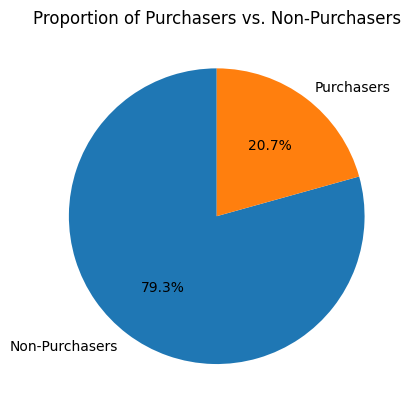

purchasers
0    92038
1    23985
Name: count, dtype: int64


In [11]:
train_data['purchasers'] = train_data['purchaseValue'].apply(lambda x: 1 if x > 0 else 0)
counts_df = train_data['purchasers'].value_counts().reset_index()
counts_df.columns = ['CustomerType', 'Count']
counts_df['CustomerType'] = counts_df['CustomerType'].map({0: 'Non-Purchasers', 1: 'Purchasers'})

plt.pie(counts_df['Count'], labels=counts_df['CustomerType'], autopct='%1.1f%%', startangle=90)
plt.title("Proportion of Purchasers vs. Non-Purchasers")
plt.show()

print(train_data['purchasers'].value_counts())

train_data.drop('purchasers', inplace=True, axis = 1)

### **Device & Technology Analysis**

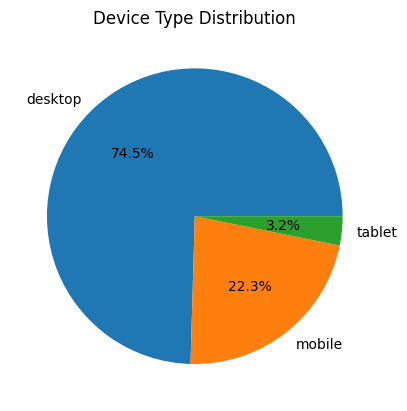

In [12]:
device_dist= train_data['deviceType'].value_counts()
plt.pie(device_dist, labels=device_dist.index, autopct="%1.1f%%")
plt.title('Device Type Distribution')
plt.show()

                  mean  count
deviceType                   
desktop    135,336,545  21884
mobile      57,355,192   1770
tablet      56,807,311    331
highest_value: desktop


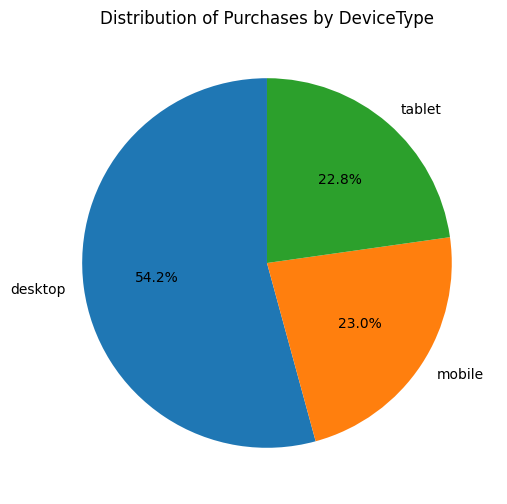

In [13]:
#Device with highest average purchase value
purchasers = train_data[train_data['purchaseValue'] > 0]
device_purchase_avg = purchasers.groupby('deviceType')['purchaseValue'].agg(['mean', 'count']).round(1)
device_purchase_avg = device_purchase_avg.sort_values('mean', ascending=False)
highest_value_device = device_purchase_avg.index[0]
print(device_purchase_avg.head(10))
print(f"highest_value: {highest_value_device}")

plt.figure(figsize=(8, 6))
plt.pie(device_purchase_avg['mean'], labels=device_purchase_avg.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Purchases by DeviceType')
plt.show()

                     mean  count
os                              
Windows       172,227,381   4677
Chrome OS     165,757,300   2148
Macintosh     127,216,609  13450
Android        74,253,091    964
Linux          55,115,867   1643
iOS            42,889,355   1101
Windows Phone  26,400,000      2
highest_value: Windows


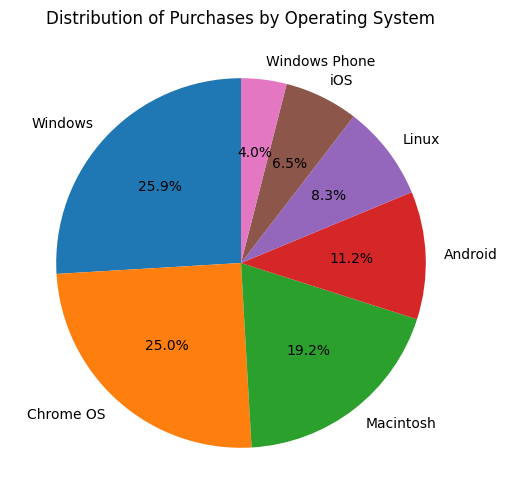

In [14]:
#OS with highest average purchase value
purchasers = train_data[train_data['purchaseValue'] > 0]  # purchasers -> purchaseValue > 0
os_purchase_avg = purchasers.groupby('os')['purchaseValue'].agg(['mean', 'count']).round(1)
os_purchase_avg = os_purchase_avg.sort_values('mean', ascending=False)
highest_value_os = os_purchase_avg.index[0]
print(os_purchase_avg.head(10))
print(f"highest_value: {highest_value_os}")

plt.figure(figsize=(8, 6))
plt.pie(os_purchase_avg['mean'], labels=os_purchase_avg.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Purchases by Operating System')
plt.show()

#### We can infer that the highest average purchaseValue is through Windows devices, but there is only a marginal difference between it and Chrome OS, followed by Macintosh.

In [15]:
#Most common OS-Browser combination for purchasers
purchasers_copy = purchasers.copy()
purchasers_copy['os_browser_combo'] = purchasers_copy['os'] + ' - ' + purchasers_copy['browser']
os_browser_counts = purchasers_copy['os_browser_combo'].value_counts()
most_common_combo = os_browser_counts.index[0]
os_part, browser_part = most_common_combo.split(' - ')
print(os_browser_counts)
print(f"Most common OS-Browser combination : ('{os_part}', '{browser_part}')")

os_browser_combo
Macintosh - Chrome             12631
Windows - Chrome                4050
Chrome OS - Chrome              2148
Linux - Chrome                  1626
Android - Chrome                 944
iOS - Safari                     883
Macintosh - Safari               690
Windows - Firefox                290
Windows - Internet Explorer      213
iOS - Chrome                     196
Macintosh - Firefox              125
Windows - Edge                   113
iOS - Safari (in-app)             22
Linux - Firefox                   17
Windows - Opera                   11
Android - Android Webview          9
Android - Samsung Internet         5
Android - Firefox                  5
Macintosh - Opera                  4
Windows Phone - Safari             2
Android - Opera                    1
Name: count, dtype: int64
Most common OS-Browser combination : ('Macintosh', 'Chrome')


#### Most common OS-Browser combination according to session count is Macintosh and Chrome

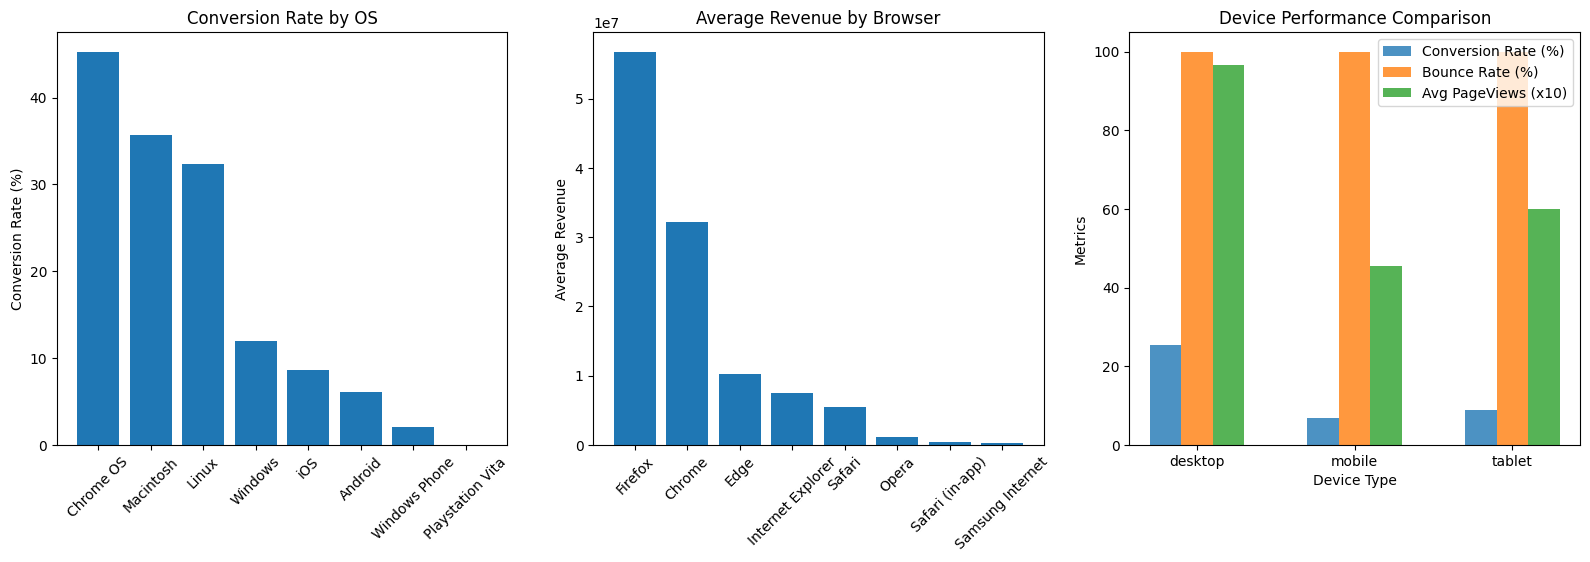

In [16]:
plt.figure(figsize=(16, 10))

# OS Performance Analysis
plt.subplot(2, 3, 1)
os_conversion = train_data.groupby('os').agg({
    'purchaseValue': [lambda x: (x > 0).mean() * 100, 'mean'],
    'totals.bounces': 'mean'
}).round(2)
os_conversion.columns = ['conversion_rate', 'avg_revenue', 'bounce_rate']
os_conversion = os_conversion.sort_values('conversion_rate', ascending=False).head(8)
plt.bar(range(len(os_conversion)), os_conversion['conversion_rate'])
plt.xticks(range(len(os_conversion)), os_conversion.index, rotation=45)
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by OS')

# Browser Performance
plt.subplot(2, 3, 2)
browser_performance = train_data.groupby('browser').agg({
    'purchaseValue': ['mean', 'count'],
    'totals.bounces': 'mean'
}).round(2)
browser_performance.columns = ['avg_revenue', 'session_count', 'bounce_rate']
browser_performance = browser_performance[browser_performance['session_count'] >= 50]
browser_performance = browser_performance.sort_values('avg_revenue', ascending=False).head(8)
plt.bar(range(len(browser_performance)), browser_performance['avg_revenue'])
plt.xticks(range(len(browser_performance)), browser_performance.index, rotation=45)
plt.ylabel('Average Revenue')
plt.title('Average Revenue by Browser')

# Device Type Deep Dive
plt.subplot(2, 3, 3)
device_performance = train_data.groupby('deviceType').agg({
    'purchaseValue': ['mean', 'sum', lambda x: (x > 0).mean() * 100],
    'totals.bounces': 'mean',
    'pageViews': 'mean'
}).round(2)
device_performance.columns = ['avg_revenue', 'total_revenue', 'conversion_rate', 'bounce_rate', 'avg_pageviews']

x = np.arange(len(device_performance.index))
width = 0.2
plt.bar(x - width, device_performance['conversion_rate'], width, label='Conversion Rate (%)', alpha=0.8)
plt.bar(x, device_performance['bounce_rate'] * 100, width, label='Bounce Rate (%)', alpha=0.8)
plt.bar(x + width, device_performance['avg_pageviews'] * 10, width, label='Avg PageViews (x10)', alpha=0.8)
plt.xlabel('Device Type')
plt.ylabel('Metrics')
plt.title('Device Performance Comparison')
plt.xticks(x, device_performance.index)
plt.legend()

plt.tight_layout()
plt.show()

#### We can infer that
#### 1. Chrome OS has the highest conversion rate despite Windows having the highest average purchaseValue.
#### 2. Firefox Browser derives the highest average revenue (lower number of Firefox users).
#### 3. Desktop has the highest conversion rate as well as average page views.

### **Geographical Analysis**

In [17]:
#Continent with highest average totalHits
continent_hits = train_data.groupby('geoNetwork.continent')['totalHits'].agg(['mean', 'count']).round(2)
continent_hits.columns = ['avg_totalHits', 'session_count']
continent_hits = continent_hits.sort_values('avg_totalHits', ascending=False)
print(continent_hits)
highest_continent = continent_hits.index[0]
print(f"Continent with highest average totalHits: {highest_continent}")

                      avg_totalHits  session_count
geoNetwork.continent                              
Americas                         15          69856
(not set)                         5            136
Oceania                           5           1606
Asia                              4          22384
Europe                            3          20294
Africa                            3           1747
Continent with highest average totalHits: Americas


In [18]:
#SubContinent with highest average totalHits
subcontinent_hits = train_data.groupby('geoNetwork.subContinent')['totalHits'].agg(['mean', 'count']).round(2)
subcontinent_hits.columns = ['avg_totalHits', 'session_count']
subcontinent_hits = subcontinent_hits.sort_values('avg_totalHits', ascending=False)
print(subcontinent_hits)
highest_subcontinent = subcontinent_hits.index[0]
print(f"SubContinent with highest average totalHits: {highest_subcontinent}")

                         avg_totalHits  session_count
geoNetwork.subContinent                              
Northern America                    16          63596
Caribbean                           10            249
South America                        6           4336
(not set)                            5            136
Micronesian Region                   5             11
Eastern Asia                         5           5036
Australasia                          5           1588
Central America                      4           1675
Western Europe                       3           6264
Southern Asia                        3           6484
Southern Africa                      3            264
Central Asia                         3            132
Southern Europe                      3           3755
Eastern Africa                       3            193
Northern Europe                      3           5998
Southeast Asia                       3           7151
Eastern Europe              

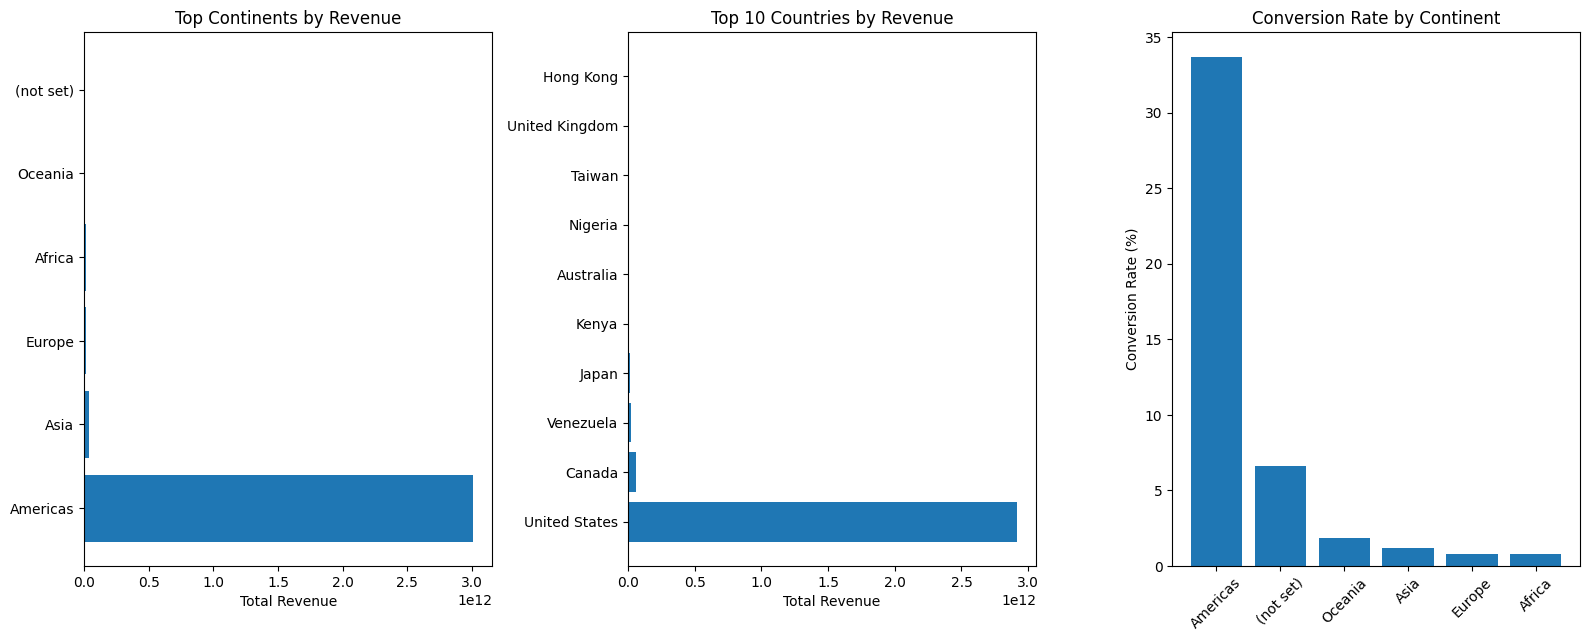

In [19]:
#Geographical Revenue Analysis
plt.figure(figsize=(16, 12))

# Top Continents by Revenue
plt.subplot(2, 3, 1)
continent_revenue = train_data.groupby('geoNetwork.continent')['purchaseValue'].sum().sort_values(ascending=False).head(10)
plt.barh(range(len(continent_revenue)), continent_revenue.values)
plt.yticks(range(len(continent_revenue)), continent_revenue.index)
plt.xlabel('Total Revenue')
plt.title('Top Continents by Revenue')

# Top Countries by Revenue
plt.subplot(2, 3, 2)
country_revenue = train_data.groupby('locationCountry')['purchaseValue'].sum().sort_values(ascending=False).head(10)
plt.barh(range(len(country_revenue)), country_revenue.values)
plt.yticks(range(len(country_revenue)), country_revenue.index)
plt.xlabel('Total Revenue')
plt.title('Top 10 Countries by Revenue')

# Conversion Rates by Continent
plt.subplot(2, 3, 3)
continent_conversion = train_data.groupby('geoNetwork.continent').agg({
    'purchaseValue': lambda x: (x > 0).mean() * 100
}).sort_values('purchaseValue', ascending=False)
plt.bar(continent_conversion.index, continent_conversion['purchaseValue'])
plt.xticks(rotation=45)
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Continent')


plt.tight_layout()
plt.show()

#### **We can infer that**
#### 1. Most of the Revenue is from the continent of America only
#### 2. Within the countries, United States leads in Total Revenue by a high margin
#### 3. Also in conversion rate, the continent of America leads. (due to the lower value count of (not set), conversion rate is shown bloated.)

### **Traffic Source Analysis**

Total sessions: 116,023
Organic sessions: 40,654


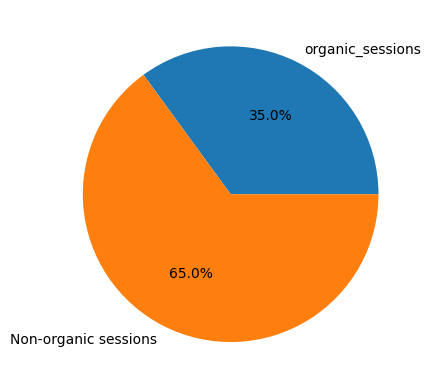

In [20]:
#Proportion of organic sessions
total_sessions = len(train_data)
organic_sessions = len(train_data[train_data['trafficSource.medium'] == 'organic'])
organic_proportion = organic_sessions / total_sessions
print(f"Total sessions: {total_sessions:,}")
print(f"Organic sessions: {organic_sessions:,}")

plt.pie([organic_sessions, total_sessions-organic_sessions], labels= ['organic_sessions', 'Non-organic sessions'], autopct='%1.1f%%')
plt.show()

#### Approx 65% of the sessions are from non organic sources

trafficSource.medium
(none)      12108
organic      6084
referral     4719
cpc           786
cpm           266
Name: count, dtype: int64
Most common source: (none)


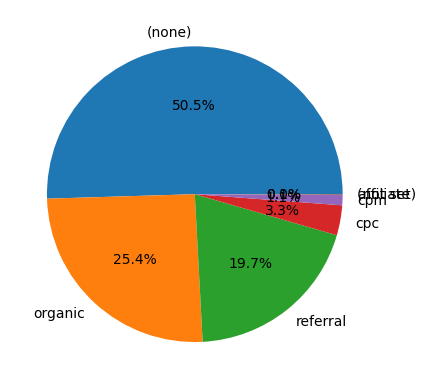

In [21]:
#Most common traffic source for purchasers
purchaser_traffic = purchasers['trafficSource.medium'].value_counts()
most_common_source = purchaser_traffic.index[0]
print(purchaser_traffic.head())
print(f"Most common source: {most_common_source}")

plt.pie(purchaser_traffic, labels= purchaser_traffic.index, autopct='%1.1f%%')
plt.show()

#### **We can infer that**
#### 1. Approx. 50% of purchases are from (none) as trafficSource.medium
#### 2. leaving (none), organic is the major medium of source

In [22]:
#Most common referral path for purchasers
referral_paths = purchasers['trafficSource.referralPath'].value_counts()
print(referral_paths.head(10))

trafficSource.referralPath
/                                                                                     10743
/mail/u/0/                                                                              110
/offer/2145                                                                              83
/a/google.com/forum/                                                                     60
/google-merchandise-store                                                                38
/a/google.com/googletopia/discounts-deals-and-free-stuff/alphabet-google-discounts       36
/deal/-ds-sign-up-for-google-merchandise-store-emails-for-special-coup-c179              25
/a/google.com/google-merchandise-store/on-site-store/mountain-view-store                 18
/yt/about/                                                                               16
/permissions/using-the-logo.html                                                         16
Name: count, dtype: int64


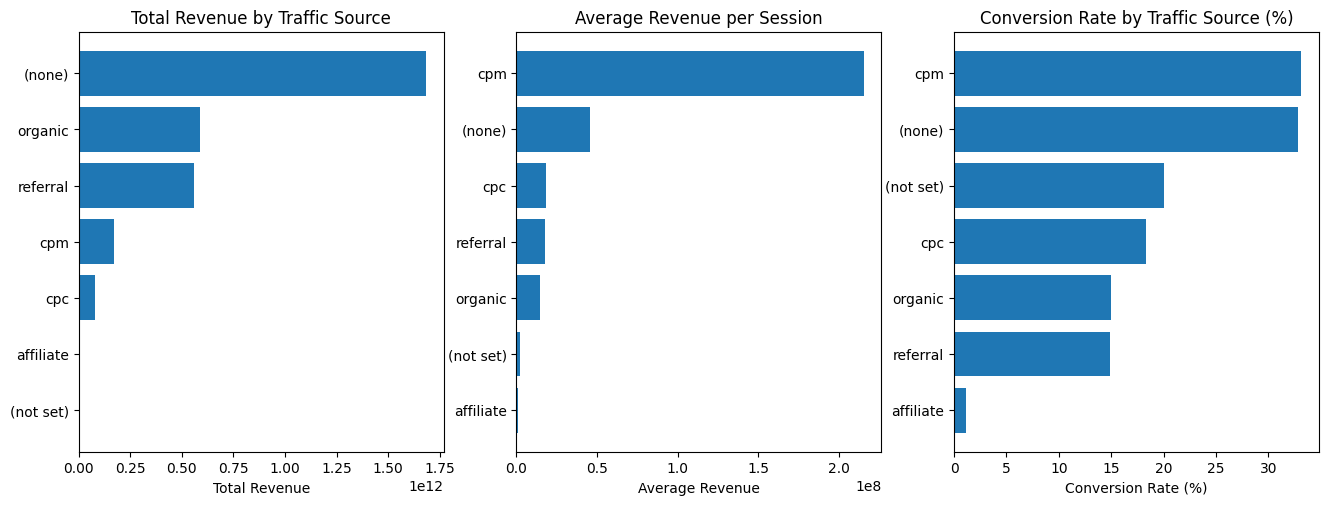

In [23]:
# Revenue per visitor by traffic source
revenue_by_source = train_data.groupby('trafficSource.medium').agg({
    'purchaseValue': ['sum', 'mean', 'count'],
    'totals.visits': 'sum'
}).round(2)

# Enhanced Revenue Source Visualization
plt.figure(figsize=(16, 12))

# 1. Revenue by Traffic Source
plt.subplot(2, 3, 1)
revenue_by_source_flat = revenue_by_source.copy()
revenue_by_source_flat.columns = ['total_revenue', 'avg_revenue', 'session_count', 'total_visits']
revenue_by_source_flat = revenue_by_source_flat.sort_values('total_revenue', ascending=True)
plt.barh(revenue_by_source_flat.index, revenue_by_source_flat['total_revenue'])
plt.title('Total Revenue by Traffic Source')
plt.xlabel('Total Revenue')

# 2. Average Revenue per Session
plt.subplot(2, 3, 2)
revenue_by_source_flat = revenue_by_source_flat.sort_values('avg_revenue', ascending=True)
plt.barh(revenue_by_source_flat.index, revenue_by_source_flat['avg_revenue'])
plt.title('Average Revenue per Session')
plt.xlabel('Average Revenue')

# 3. Conversion Rate by Traffic Source
plt.subplot(2, 3, 3)
conversion_by_source = train_data.groupby('trafficSource.medium').agg({
    'purchaseValue': lambda x: (x > 0).mean() * 100
}).round(2)
conversion_by_source = conversion_by_source.sort_values('purchaseValue', ascending=True)
plt.barh(conversion_by_source.index, conversion_by_source['purchaseValue'])
plt.title('Conversion Rate by Traffic Source (%)')
plt.xlabel('Conversion Rate (%)')

plt.show()

#### **We can infer that**
#### 1. (none) as medium of trafficSource leads in total revenue; moreover, organic and referral contribute approximately the same level of total revenue.
#### 2. cpm leads in average revenue with a high margin
#### 3. conversion rate for cpm and (none) is higher than other mediums and approximately same.

### **Correlation Analysis**

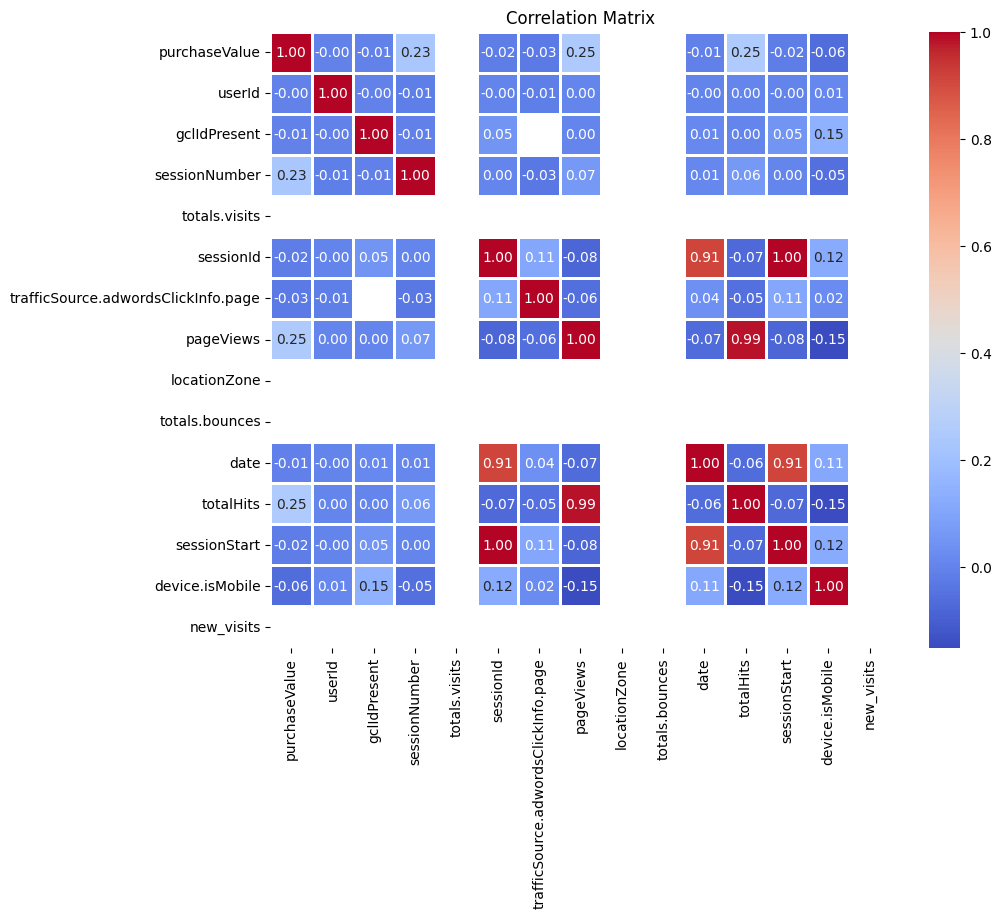

In [24]:
# Correlation Matrix for all numeric columns with purchaseValue
corr_matrix = train_data.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot = True, linewidths=1, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### **We can infer that:**
#### 1. There is a slight correlation between purchaseValue with sessionNumber, pageViews and totalHits but we can say there is no correlation with other features.
#### 2. totals.visits, locationZone, and totals.bounces have only one unique value, thus no correlation.
#### 3. date and sessionStart have a high correlation.
#### 4. sessionId and sessionStart have a high correlation. (keeping sessionStart with feature engineering).
#### 5. totalHits and pageViews too have high correlation

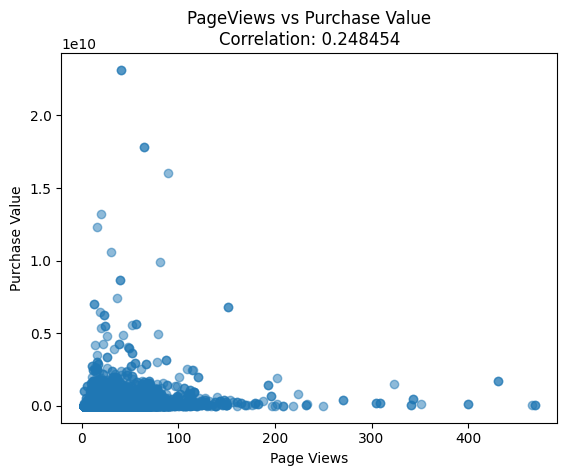

In [25]:
#Correlation between PageViews and purchaseValue for non-bounce users (pageViews > 1)
non_bounce_users = train_data[train_data['pageViews'] > 1].copy()

#use only available data
valid_data = non_bounce_users.dropna(subset=['pageViews', 'purchaseValue'])
views_purchase_corr = train_data[['pageViews', 'purchaseValue']].dropna().corr().iloc[0,1]
# PageViews vs Purchase Value Scatter
plt.scatter(valid_data['pageViews'], valid_data['purchaseValue'], alpha=0.5)
plt.xlabel('Page Views')
plt.ylabel('Purchase Value')
plt.title(f'PageViews vs Purchase Value\nCorrelation: {views_purchase_corr:3f}')
plt.show()

#### We can infer from scatter plot that there is very little correlation between pageViews and purchaseValue

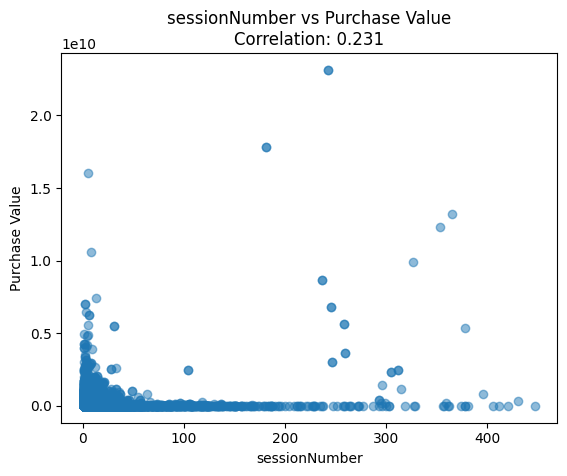

In [26]:
#Correlation between sessionNumber and purchaseValue
session_data = train_data.copy()

#use only available data
valid_data = session_data.dropna(subset=['sessionNumber', 'purchaseValue'])
session_purchase_corr = train_data[['sessionNumber', 'purchaseValue']].dropna().corr().iloc[0,1]
# sessionNumber vs Purchase Value Scatter
plt.scatter(valid_data['sessionNumber'], valid_data['purchaseValue'], alpha=0.5)
plt.xlabel('sessionNumber')
plt.ylabel('Purchase Value')
plt.title(f'sessionNumber vs Purchase Value\nCorrelation: {session_purchase_corr:.3f}')
plt.show()

#### We can infer from scatter plot that there is very little correlation between sessionNumber and purchaseValue.

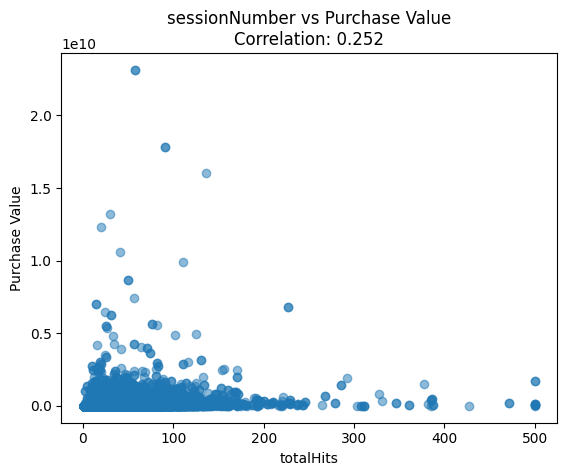

In [27]:
#Correlation between totalHits and purchaseValue
hits_data = train_data.copy()

#use only available data
valid_data = hits_data.dropna(subset=['totalHits', 'purchaseValue'])
hits_purchase_corr = train_data[['totalHits', 'purchaseValue']].dropna().corr().iloc[0,1]

# sessionNumber vs Purchase Value Scatter
plt.scatter(valid_data['totalHits'], valid_data['purchaseValue'], alpha=0.5)
plt.xlabel('totalHits')
plt.ylabel('Purchase Value')

plt.title(f'sessionNumber vs Purchase Value\nCorrelation: {hits_purchase_corr:.3f}')
plt.show()

#### We can infer from scatter plot that there is very little correlation between totalHits and purchaseValue

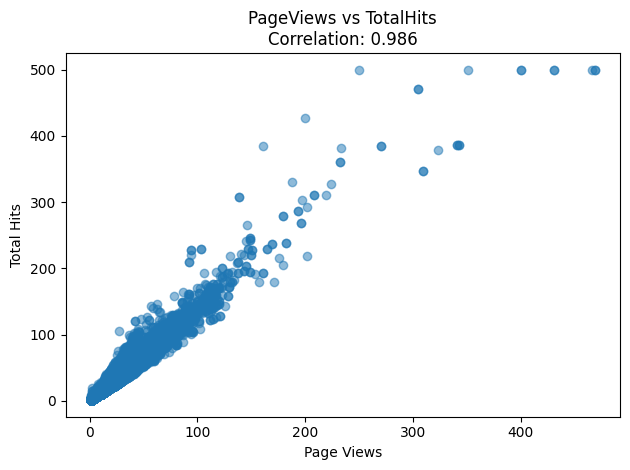

In [28]:
#High correlation check
hits_views_corr = train_data[['totalHits', 'pageViews']].dropna().corr().iloc[0,1]
valid_data = hits_data.dropna(subset=['pageViews', 'totalHits'])
# TotalHits vs PageViews relationship
plt.scatter(valid_data['pageViews'], valid_data['totalHits'], alpha=0.5)
plt.xlabel('Page Views')
plt.ylabel('Total Hits')
plt.title(f'PageViews vs TotalHits\nCorrelation: {hits_views_corr:.3f}')

plt.tight_layout()
plt.show()

#### We can infer from scatter plot that there is a high correlation between pageViews and totalHits

### **Behavior Analysis**

In [29]:
# Quick Look at the User multi session behaviour
if 'userId' in train_data.columns:
    sessions_per_user = train_data.groupby('userId').size()
    print(f"\nMulti-Session Insights:")
    print(f"Total unique users: {len(sessions_per_user):,}")
    print(f"Total sessions: {len(train_data):,}")
    print(f"Average sessions per user: {sessions_per_user.mean():.2f}")
    print(f"Users with multiple sessions: {(sessions_per_user > 1).sum()}")
    print(f"Max sessions for a user: {sessions_per_user.max()}")


Multi-Session Insights:
Total unique users: 100,499
Total sessions: 116,023
Average sessions per user: 1.15
Users with multiple sessions: 10885
Max sessions for a user: 63


In [30]:
# Hit ratio between purchasers and non-purchasers
non_purchasers = train_data[train_data['purchaseValue'] == 0]
avg_hits_purchasers = purchasers['totalHits'].mean()
avg_hits_non_purchasers = non_purchasers['totalHits'].mean()
hit_ratio = avg_hits_purchasers / avg_hits_non_purchasers

print(f"Average hits (purchasers): {avg_hits_purchasers:.2f}")
print(f"Average hits (non-purchasers): {avg_hits_non_purchasers:.2f}")
print(f"hit_ratio: {hit_ratio:.2f}")

Average hits (purchasers): 35.51
Average hits (non-purchasers): 4.12
hit_ratio: 8.62


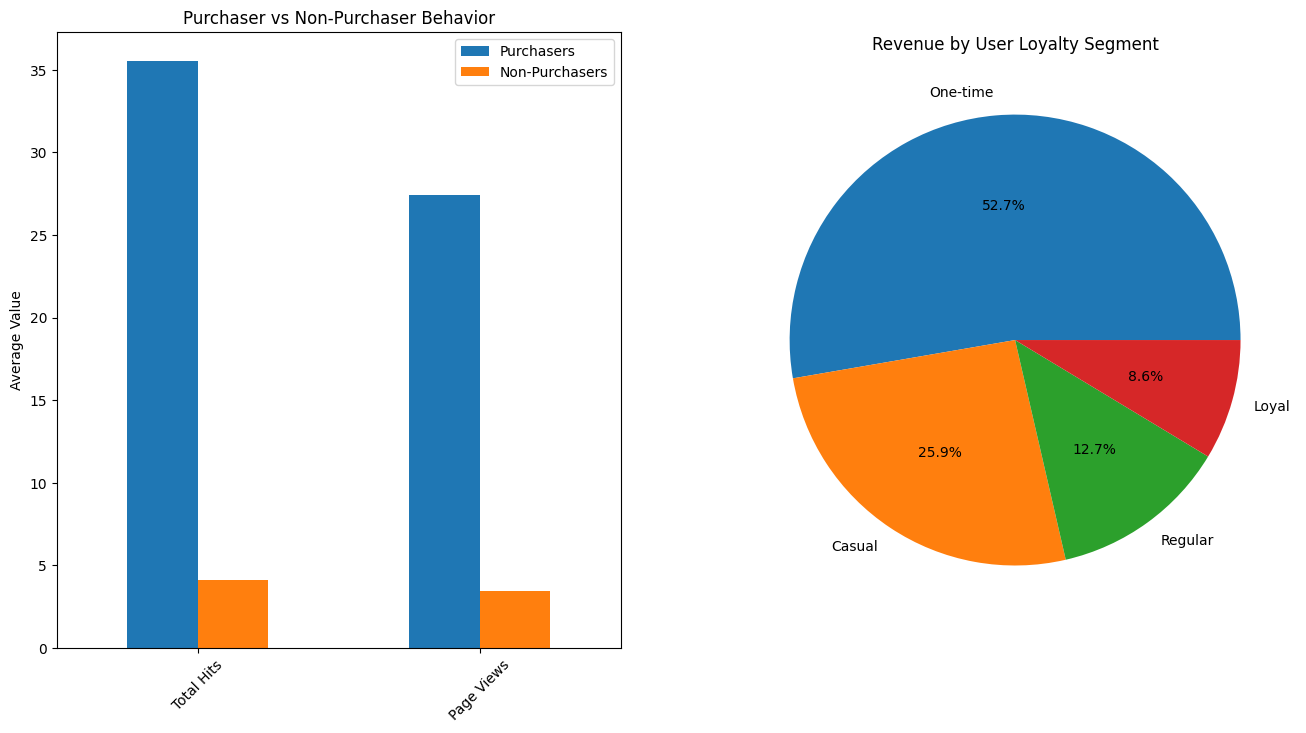

In [31]:
plt.figure(figsize=(16, 8))

# Purchaser vs Non-Purchaser Behavior Comparison
plt.subplot(1, 2, 1)
behavior_comparison = pd.DataFrame({
    'Purchasers': [
        purchasers['totalHits'].mean(),
        purchasers['pageViews'].mean(),
    ],
    'Non-Purchasers': [
        non_purchasers['totalHits'].mean(),
        non_purchasers['pageViews'].mean(),
    ]
}, index=['Total Hits', 'Page Views'])

behavior_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Purchaser vs Non-Purchaser Behavior')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend()


# User Loyalty Analysis
plt.subplot(1, 2, 2)
user_loyalty = train_data.groupby('userId').agg({
    'purchaseValue': 'sum',
    'sessionId': 'nunique'
}).rename(columns={'sessionId': 'session_count'})

loyalty_segments = pd.cut(user_loyalty['session_count'], 
                         bins=[0, 1, 3, 10, float('inf')], 
                         labels=['One-time', 'Casual', 'Regular', 'Loyal'])
loyalty_revenue = user_loyalty.groupby(loyalty_segments, observed=True)['purchaseValue'].sum()

plt.pie(loyalty_revenue.values, labels=loyalty_revenue.index, autopct='%1.1f%%')
plt.title('Revenue by User Loyalty Segment')
plt.show()

#### **We can infer that**
#### 1. Purchasers have significantly high average totalHits as well as PageViews than the non-Purchasers.
#### 2. Most of the revenue is by the one-time user (approximately 53 percent).
#### 3. There are 8.6% users who are loyal and have purchased more than 10 times, and 12.7% of users have purchased between 3 to 10 times.

## **Preprocessing**

In [32]:
#dropping columns which have just one cardinality, ID related and redundant columns 
drop_cols = [
    'userId', 'sessionId', 'date', 
    'device.browserVersion', 'device.operatingSystemVersion', 'device.language', 'device.flashVersion',
    'device.screenResolution', 'device.screenColors', 'screenSize', 'device.browserSize', 
    'device.isMobile', 'device.mobileDeviceBranding', 'device.mobileDeviceModel',
    'device.mobileInputSelector', 'device.mobileDeviceMarketingName',
    'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 
    'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.adNetworkType', 
    'geoNetwork.networkDomain', 'geoNetwork.networkLocation', 'geoNetwork.metro', 'geoNetwork.region',
    'locationZone', 'browserMajor', 'socialEngagementType'
]

# Drop from train
X = train_data.drop(columns=drop_cols + ['purchaseValue'], errors='ignore')
y = train_data['purchaseValue']

# Drop from test
test_data = test_data.drop(columns=drop_cols, errors='ignore')

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   trafficSource.isTrueDirect  42890 non-null   object 
 1   browser                     116023 non-null  object 
 2   trafficSource.adContent     2963 non-null    object 
 3   trafficSource.keyword       44162 non-null   object 
 4   geoCluster                  116023 non-null  object 
 5   trafficSource.campaign      116023 non-null  object 
 6   gclIdPresent                116023 non-null  int64  
 7   sessionNumber               116023 non-null  int64  
 8   trafficSource               116023 non-null  object 
 9   totals.visits               116023 non-null  int64  
 10  os                          116023 non-null  object 
 11  geoNetwork.subContinent     116023 non-null  object 
 12  trafficSource.medium        116023 non-null  object 
 13  locationCountr

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   userChannel                 29006 non-null  object 
 1   browser                     29006 non-null  object 
 2   deviceType                  29006 non-null  object 
 3   os                          29006 non-null  object 
 4   geoNetwork.city             29006 non-null  object 
 5   geoNetwork.continent        29006 non-null  object 
 6   locationCountry             29006 non-null  object 
 7   geoNetwork.subContinent     29006 non-null  object 
 8   totals.bounces              11732 non-null  float64
 9   totalHits                   29006 non-null  int64  
 10  new_visits                  20094 non-null  float64
 11  pageViews                   29003 non-null  float64
 12  totals.visits               29006 non-null  int64  
 13  trafficSource.adContent     759

#### 1. Since **trafficSource.isTrueDirect** has null values but only one unique value, i.e., True, thus making it a binary flag, replacing all null values by False and then converting them into the respective integers 1 and 0.

#### 2. There are columns like **trafficSource.adContent, trafficSource.keyword, trafficSource.referralPath** that have high cardinality and also have null values, thus transforming them into binary flags based on having a value or not and then converting them into the respective integers 1 and 0.

#### 3. Column **trafficSource.campaign** also has high cardinality but almost 90 percent value are ***(not set)*** so it is transformed into a binary flag.

In [35]:
#using FunctionalTransform to convert columns into binary flags
is_true_direct_tf = FunctionTransformer(
    lambda x: (~x.isna() & x.astype(bool)).astype(int), 
    validate=False
)
has_value_tf = FunctionTransformer(
    lambda x: (~x.isna()).astype(int), 
    validate=False
)
has_campaign_tf = FunctionTransformer(
    lambda x: (x != '(not set)').astype(int), 
    validate=False
)

#### Grouping rare values for high cardinality columns

In [36]:
# for trafficSource
traffic_counts = X['trafficSource'].value_counts()
common_sources = traffic_counts[traffic_counts >= 500].index
group_rare_traffic_tf = FunctionTransformer(
    lambda x: x.where(x.isin(common_sources), other='others'), validate=False
)

# for browser
browser_counts = X['browser'].value_counts()
common_browser = browser_counts[browser_counts >= 500].index
group_rare_browser_tf = FunctionTransformer(
    lambda x: x.where(x.isin(common_browser), other='others'), validate=False
)

# for OS
os_counts = X['os'].value_counts()
common_os = os_counts[os_counts >= 600].index
group_rare_os_tf = FunctionTransformer(
    lambda x: x.where(x.isin(common_os), other='others'), validate=False
)

# for subContinent
subContinent_counts = X['geoNetwork.subContinent'].value_counts()
common_subContinent = subContinent_counts[subContinent_counts >= 1000].index
group_rare_sc_tf = FunctionTransformer(
    lambda x: x.where(x.isin(common_subContinent), other='others'), validate=False
)

#### Feature Engineering the **sessionStart** Column as it contains various important temporal features

In [37]:
# Transformer for sessionStart features
session_start_feature_transformer = FunctionTransformer(
    lambda df: pd.DataFrame({
        'session_hour': pd.to_datetime(df.iloc[:, 0], unit='s').dt.hour,
        'session_dayofweek': pd.to_datetime(df.iloc[:, 0], unit='s').dt.dayofweek, # Monday=0, Sunday=6
        'session_dayofyear': pd.to_datetime(df.iloc[:, 0], unit='s').dt.dayofyear,
        'session_weekofyear': pd.to_datetime(df.iloc[:, 0], unit='s').dt.isocalendar().week.astype(int),
        'session_month': pd.to_datetime(df.iloc[:, 0], unit='s').dt.month,
        'session_year': pd.to_datetime(df.iloc[:, 0], unit='s').dt.year,
        'session_is_weekend': pd.to_datetime(df.iloc[:, 0], unit='s').dt.dayofweek.isin([5, 6]).astype(int)
    }),
    validate=False
)

#### Column **trafficSource.referralPath** have high cardinality so extracting the depth of referral from it and storing it as int.
#### creating new ratio features from the existing feature like **hits_per_visit, pageviews_per_hit, log_pageviews**

In [38]:
# Transformer for referral depth
referral_depth_transformer = FunctionTransformer(
    lambda df: pd.DataFrame(df.iloc[:, 0].str.count('/').fillna(0)),
    validate=False
)

# Transformer for ratio features
ratio_transformer = FunctionTransformer(
    lambda df: pd.DataFrame({
        'hits_per_visit': df['totalHits'] / df['totals.visits'].replace(0, np.nan),
        'pageviews_per_hit': df['pageViews'] / df['totalHits'].replace(0, np.nan),
        'log_pageviews': np.log1p(df['pageViews'])
    }).fillna(0),
    validate=False
)

In [39]:
# Initializing Encoders and Imputers
ohe = lambda: OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

impute_zeros = SimpleImputer(strategy='constant', fill_value=0)

#### 1. One-hot Encoding the low cardinality features like ***trafficSource, browser, os, geoNetwork.subContinent, trafficSource.medium, userChannel, geoNetwork.continent, deviceType, and geoCluster***
#### 2. Ordinal Encoding the high cardinality features like ***locationCountry, geoNetwork.city***
#### 3. Imputing the null values with mean for some columns which have low null values like ***totals.bounces, new_visits, pageViews***

In [40]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    # Binary features
    ('is_true_direct', is_true_direct_tf, ['trafficSource.isTrueDirect']),
    ('has_ad_content', has_value_tf, ['trafficSource.adContent']),
    ('has_keyword', has_value_tf, ['trafficSource.keyword']),
    ('has_referral_path', has_value_tf, ['trafficSource.referralPath']),
    ('has_campaign', has_campaign_tf, ['trafficSource.campaign']),

    # Grouping rare + OHE
    ('traffic_ohe', Pipeline(steps=[
        ('group_rare_traffic', group_rare_traffic_tf),
        ('ohe1', ohe())
    ]), ['trafficSource']),

    ('browser_ohe', Pipeline(steps=[
        ('group_rare_browsers', group_rare_browser_tf),
        ('ohe2', ohe())
    ]), ['browser']),

    ('os_ohe', Pipeline(steps=[
        ('group_rare_os', group_rare_os_tf),
        ('ohe3', ohe())
    ]), ['os']),

    ('sc_ohe', Pipeline(steps=[
        ('group_rare_subContinent', group_rare_sc_tf),
        ('ohe4', ohe())
    ]), ['geoNetwork.subContinent']),

    ('medium_ohe', ohe(), ['trafficSource.medium']),

    # OHE
    ('user_channel_ohe', ohe(), ['userChannel']),
    ('continent_ohe', ohe(), ['geoNetwork.continent']),
    ('device_type_ohe', ohe(), ['deviceType']),
    ('cluster_ohe', ohe(), ['geoCluster']),

    # Ordinal Encoding
    ('country_ord', ordinal_enc, ['locationCountry']),
    ('city_ord', ordinal_enc, ['geoNetwork.city']),

    # Impute zeros
    ('bounces', impute_zeros, ['totals.bounces']),
    ('is_new_visit', impute_zeros, ['new_visits']),
    ('pageViews', impute_zeros, ['pageViews']),

    # feature transformers
    ('session_start_features', Pipeline(steps=[
        ('extract', session_start_feature_transformer)
    ]), ['sessionStart']),
    
    ('referral_depth', Pipeline(steps=[
        ('compute', referral_depth_transformer)
    ]), ['trafficSource.referralPath']),
    
    ('ratio_features', Pipeline(steps=[
        ('compute', ratio_transformer)
    ]), ['totalHits', 'totals.visits', 'pageViews']),

], remainder='drop')

#### **Transforming the columns**

In [41]:
# Include all needed columns
X_selected = X[[
    'trafficSource.isTrueDirect', 'trafficSource.adContent', 'trafficSource.keyword',
    'trafficSource.referralPath', 'trafficSource.campaign',
    'trafficSource', 'browser', 'os', 'geoNetwork.subContinent', 'trafficSource.medium',
    'locationCountry', 'geoNetwork.city', 'totals.bounces', 'new_visits','pageViews',
    'userChannel', 'geoNetwork.continent', 'deviceType', 'geoCluster',
    'sessionStart', 'totalHits', 'totals.visits'
]]

print(f"Before Preprocessing: {X.shape[1]} features")

# Transform
X_transformed = preprocessor.fit_transform(X_selected)

# OneHotEncoders with get_feature_names_out
traffic_ohe_cols = preprocessor.named_transformers_['traffic_ohe'].named_steps['ohe1'].get_feature_names_out(['trafficSource'])
browser_ohe_cols = preprocessor.named_transformers_['browser_ohe'].named_steps['ohe2'].get_feature_names_out(['browser'])
os_ohe_cols = preprocessor.named_transformers_['os_ohe'].named_steps['ohe3'].get_feature_names_out(['os'])
sc_ohe_cols = preprocessor.named_transformers_['sc_ohe'].named_steps['ohe4'].get_feature_names_out(['geoNetwork.subContinent'])
medium_ohe_cols = preprocessor.named_transformers_['medium_ohe'].get_feature_names_out(['trafficSource.medium'])
user_channel_ohe_cols = preprocessor.named_transformers_['user_channel_ohe'].get_feature_names_out(['userChannel'])
continent_ohe_cols = preprocessor.named_transformers_['continent_ohe'].get_feature_names_out(['geoNetwork.continent'])
device_type_ohe_cols = preprocessor.named_transformers_['device_type_ohe'].get_feature_names_out(['deviceType'])
cluster_ohe_cols = preprocessor.named_transformers_['cluster_ohe'].get_feature_names_out(['geoCluster'])
session_start_feature_cols = ['session_hour', 'session_dayofweek', 'session_dayofyear', 'session_weekofyear', 'session_month', 'session_year', 'session_is_weekend']
ratio_feature_cols = ['hits_per_visit', 'pageviews_per_hit', 'log_pageviews']


# Final column names
transformed_cols = (
    ['is_true_direct', 'has_ad_content', 'has_keyword', 'has_referral_path', 'has_campaign'] +
    list(traffic_ohe_cols) + list(browser_ohe_cols) + list(os_ohe_cols) +list(sc_ohe_cols) + list(medium_ohe_cols) +
    list(user_channel_ohe_cols) + list(continent_ohe_cols) + list(device_type_ohe_cols) + list(cluster_ohe_cols) +
    ['locationCountry_encoded', 'geoNetwork.city_encoded', 'bounces', 'is_new_visit', 'pageViews'] +
    list(session_start_feature_cols) + ['referral_depth']+ list(ratio_feature_cols)
)

# Build final DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_cols, index=X.index)

# Combine with other features
X_final = pd.concat([X.drop(columns=X_selected.columns), X_transformed_df], axis=1)

# numeric_cols = X_final.select_dtypes(include=['float64', 'int64']).columns.tolist()
# scaler = StandardScaler()
# X_final[numeric_cols] = scaler.fit_transform(X_final[numeric_cols])

print(f"After Preprocesing Final shape: {X_final.shape}")
X = X_final

Before Preprocessing: 24 features
After Preprocesing Final shape: (116023, 93)


#### **Transforming test_data using same preprocesor pipeline for consitency**

In [42]:
#test_data Transformation
test_selected = test_data[X_selected.columns]

test_transformed = preprocessor.transform(test_selected)

test_transformed_df = pd.DataFrame(test_transformed, columns=transformed_cols, index=test_data.index)
test_final = pd.concat([test_data.drop(columns=X_selected.columns), test_transformed_df], axis=1)

test_data = test_final

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 93 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   gclIdPresent                              116023 non-null  int64  
 1   sessionNumber                             116023 non-null  int64  
 2   is_true_direct                            116023 non-null  float64
 3   has_ad_content                            116023 non-null  float64
 4   has_keyword                               116023 non-null  float64
 5   has_referral_path                         116023 non-null  float64
 6   has_campaign                              116023 non-null  float64
 7   trafficSource_(direct)                    116023 non-null  float64
 8   trafficSource_Partners                    116023 non-null  float64
 9   trafficSource_analytics.google.com        116023 non-null  float64
 10  trafficSource_dfa   

In [44]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 93 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   sessionNumber                             29006 non-null  int64  
 1   gclIdPresent                              29006 non-null  int64  
 2   is_true_direct                            29006 non-null  float64
 3   has_ad_content                            29006 non-null  float64
 4   has_keyword                               29006 non-null  float64
 5   has_referral_path                         29006 non-null  float64
 6   has_campaign                              29006 non-null  float64
 7   trafficSource_(direct)                    29006 non-null  float64
 8   trafficSource_Partners                    29006 non-null  float64
 9   trafficSource_analytics.google.com        29006 non-null  float64
 10  trafficSource_dfa                 

## **Train-Validation Split**

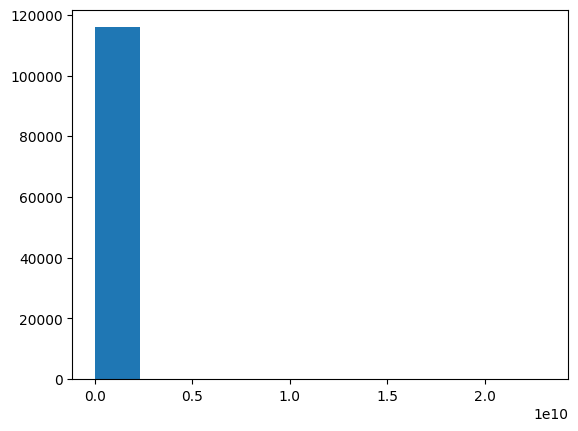

In [45]:
# y.value_counts()
plt.hist(y)
plt.show()

#### **y is  highly right-skewed**; 
#### hence, binning of the y in different strata will make it more evenly distributed during the train-test split.

#### * Both train/val sets have proportional representation of zeros
#### * Both sets have proportional representation across the non-zero value ranges

In [46]:
# Binning of y
y_binned = pd.Series(index=y.index, dtype=object)
is_zero = (y == 0)
y_binned[is_zero] = 'zero'
non_zero_values = y[~is_zero]
num_bins_for_non_zeros = 10
non_zero_bins = pd.qcut(
    non_zero_values,
    q=num_bins_for_non_zeros,
    labels=[f'non_zero_bin_{i}' for i in range(num_bins_for_non_zeros)]
)
y_binned[~is_zero] = non_zero_bins

# Train Test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

# Making sure test_data have same columns and in same order
test_data = test_data[X_train.columns]

## **Model Training**

#### **Training baseline model**

In [47]:
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X_val)
print("R2 Score (Linear Regression):", r2_score(y_val, y_pred))

R2 Score (Linear Regression): 0.14452000275276644


In [48]:
rd = Ridge()
rd.fit(X_train, y_train)
y_pred_rd = rd.predict(X_val)
print("R2 Score (Ridge):", r2_score(y_val, y_pred_rd))

R2 Score (Ridge): 0.1422810758789017


In [49]:
ls = Lasso(
    alpha=5,
    random_state=42,
    max_iter=1000,
    tol=1e3
)
ls.fit(X_train, y_train)
y_pred_ls = ls.predict(X_val)
print("R2 Score (Lasso):", r2_score(y_val, y_pred_ls))

R2 Score (Lasso): 0.12320511240053011


#### Training tree-based ensemble models

In [50]:
rfr_0 = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rfr_0.fit(X_train, y_train)
y_pred_rf_0 = rfr_0.predict(X_val)
y_pred_rf_0 = np.maximum(y_pred_rf_0, 0)
print("R2 Score (Random Forest):", r2_score(y_val, y_pred_rf_0))

R2 Score (Random Forest): 0.4527138248683955


In [51]:
rfr = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rfr.fit(X, y)
y_pred_rf = rfr.predict(X_val)
y_pred_rf = np.maximum(y_pred_rf, 0)
print("R2 Score (Random Forest):", r2_score(y_val, y_pred_rf))

R2 Score (Random Forest): 0.9271440244691312


In [52]:
lgbm= lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    early_stopping=50,
    verbose=-1,
    subsample=0.8,
    random_state=42
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])

y_pred = lgbm.predict(X_val)
print("R2 Score (LightGBM):", r2_score(y_val, y_pred))

R2 Score (LightGBM): 0.260190617133643


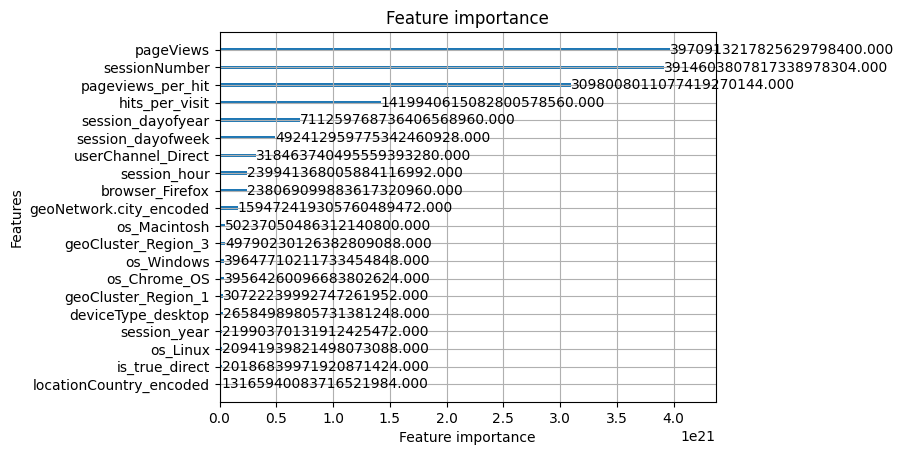

In [53]:
lgb.plot_importance(lgbm, max_num_features=20, importance_type='gain')
plt.show()

In [54]:
gbr = GradientBoostingRegressor(n_estimators=1000,
                                learning_rate=0.1,
                                max_depth=15,
                                subsample=0.8,
                                random_state=42)


gbr.fit(X, y)
y_pred_gb = gbr.predict(X_val)
y_pred_gb = np.maximum(y_pred_gb, 0)
print("R2 Score (GBRegressor):", r2_score(y_val, y_pred_gb))

R2 Score (GBRegressor): 0.9999969090662564


In [55]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

lgb_log = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    random_state=42,
    early_stopping_rounds=50, 
    verbose=-1
)

lgb_log.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)])
y_pred_log = lgb_log.predict(X_val)
y_pred_log_inverse = np.expm1(y_pred_log)
r2_log = r2_score(y_val, y_pred_log_inverse)
print(f"Log-Transformed Target R² Score: {r2_log:.4f}")

Log-Transformed Target R² Score: 0.0502


In [56]:
xgbr = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50, 
    verbosity=1
)
xgbr.fit(X, y, eval_set=[(X_val, y_val)], verbose=False)
y_pred_xgbr = xgbr.predict(X_val)
print("R2 Score (XGBoost):", r2_score(y_val, y_pred_xgbr))

R2 Score (XGBoost): 0.9942940296032177


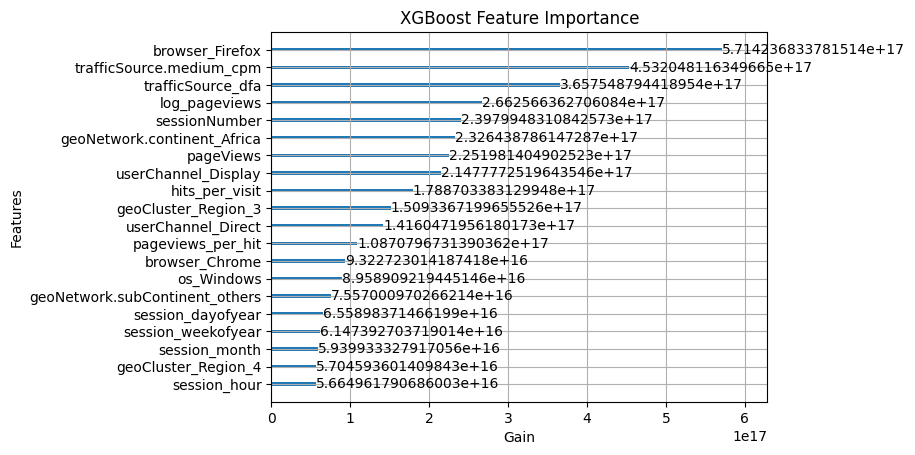

In [57]:
xgb.plot_importance(xgbr, max_num_features=20, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.xlabel("Gain")
plt.ylabel("Features")
plt.show()

In [58]:
param_dist_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [10, 15],
    'subsample': [0.6, 0.8,],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.25],
    'reg_lambda': [1,1.5]
}

# Initialize XGBoost model without early stopping
xgbrm = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Create RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgbrm,
    param_distributions=param_dist_xgb,
    n_iter=50,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# # Create GridSearchCV
# grid_search_xgb = GridSearchCV(
#     estimator=xgbrm,
#     param_grid=param_dist_xgb,
#     cv=3,
#     scoring='r2',
#     verbose=2,
#     n_jobs=-1
# )

print("Starting XGBoost Regressor RandomizedSearchCV...")
random_search_xgb.fit(X_train, y_train)
print("XGBoost Regressor RandomizedSearchCV finished.")

# print("Starting XGBoost Regressor GridSearchCV...")
# grid_search_xgb.fit(X_train, y_train)
# print("XGBoost Regressor GridSearchCV finished.")

print("\nBest parameters for XGBoost Regressor:", random_search_xgb.best_params_)
print("Best cross-validation MSE for XGBoost Regressor:", -random_search_xgb.best_score_)

# print("\nBest parameters for XGBoost Regressor:", grid_search_xgb.best_params_)
# print("Best cross-validation MSE for XGBoost Regressor:", -grid_search_xgb.best_score_)

best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_val)
print("XGBoost Test Set R2 Score:", r2_score(y_val, y_pred_xgb))

Starting XGBoost Regressor RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=10, n_estimators=200, reg_alpha=0.25, reg_lambda=1, subsample=0.8; total time=  11.8s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=10, n_estimators=200, reg_alpha=0.25, reg_lambda=1, subsample=0.8; total time=  11.6s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=10, n_estimators=200, reg_alpha=0.25, reg_lambda=1, subsample=0.8; total time=  10.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=  29.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=  29.4s
[CV] END colsample_bytree=0.8, learning_rate=0.001, max_depth=15, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time= 1.1min
[CV] END col

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=15, n_estimators=100, reg_alpha=0.25, reg_lambda=1.5, subsample=0.6; total time=  15.2s
[CV] END colsample_bytree=0.8, learning_rate=0.001, max_depth=15, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  31.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, reg_alpha=0.25, reg_lambda=1, subsample=0.6; total time=  27.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=  10.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=15, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=  16.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=15, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.6; t

Best parameters for XGBoost Regressor: {'subsample': 0.6, 'reg_lambda': 1.2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best cross-validation MSE for XGBoost Regressor: -0.19671959973146586
XGBoost Test Set R2 Score: 0.4402548285356689

#### **Training Voting Regressor for the Best Performing Models**

In [59]:
# Create diverse base models for voting
base_models = [
    ('xgb', xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
        )),
    ('gbr', GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=15,
        subsample=0.8,
        random_state=42))
]

# Weighted Voting Regressor (give more weight to better performing models)
weights = [0.4, 0.6]      

weighted_voting = VotingRegressor(
    estimators=base_models,
    weights=weights,
    n_jobs=-1
)

print("Training Weighted Voting Regressor...")
weighted_voting.fit(X, y)

y_pred_weighted = weighted_voting.predict(X_val)
y_pred_weighted = np.maximum(y_pred_weighted, 0)

r2_weighted = r2_score(y_val, y_pred_weighted)

print(f"Weighted Voting Regressor R2: {r2_weighted:.4f}")

Training Weighted Voting Regressor...
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=15, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=  16.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=15, n_estimators=200, reg_alpha=0.25, reg_lambda=1.5, subsample=0.8; total time=  32.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=  11.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=  10.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=  11.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, reg_alpha=0.25, reg_lambda=1, subsample=0.8; total time=  28.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, re

#### **Final Predictions**

In [60]:
predictions = weighted_voting.predict(test_data)
predictions = np.maximum(predictions, 0)  # replacing all the -ve from the predictions to 0
predictions.shape

(29006,)

#### **Creating Submission File**

In [61]:
submission = pd.DataFrame({
    'id': range(0,test_data.shape[0]),
    'purchaseValue': predictions
})
submission.to_csv('submission.csv', index=False)